In [47]:
# Append 'src' directory to import modules from notebooks directory
#################################
import os,sys
src_dir = os.path.join(os.getcwd(), os.pardir)
sys.path.append(src_dir)
##################################

In [48]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 150)

import time
import os 
from src.PatchMatch import PatchMatchOrig
import torchvision.models as models
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.model_zoo as model_zoo
import cv2
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
from collections import OrderedDict
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


/home/harsh/ml/Deep-Image-Analogy/.venv/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['show']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [306]:
# cnn = models.vgg19_bn(pretrained=True).features
# cnn = models.vgg19(pretrained=True).features
cnn = models.vgg16(pretrained=True).features

In [307]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

    def add_layer(self,name, layer):
        self.add_module(name, layer)
    
    def forward(self,x):
        list = []
        for module in self._modules:
            x = self._modules[module](x)
            list.append(x)
        return list

In [308]:
model_t = FeatureExtractor()  # the new Feature extractor module network
i = 1
conv_counter = 1
relu_counter = 1
pool_counter = 1
batn_counter = 1

block_counter = 1

for layer in list(cnn):
    
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(block_counter) + "_"+str(conv_counter)
        conv_counter +=1
        model_t.add_layer(name, layer)

    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(block_counter) + "_"+str(relu_counter)
        relu_counter +=1
        model_t.add_layer(name, layer)

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(block_counter) 
        pool_counter = bn_counter = relu_counter = conv_counter= 1
        block_counter +=1
        model_t.add_layer(name, layer)  # ***
        
    if isinstance(layer, nn.BatchNorm2d):
        name = "batn_" + str(block_counter) + "_"+str(batn_counter)
        batn_counter +=1
        model_t.add_layer(name, layer)  # ***


In [331]:

loader = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

def image_loader(img_path):
    ava = cv2.imread(img_path)
    ava = cv2.resize(ava,(448,448))
#     ava = ava/255
#     ava = ava[:,:,::-1].copy()
#     ava = np.transpose(ava,(2,0,1))

    image = Variable(loader(ava))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image


# t = Variable(torch.from_numpy(np.random.random(size=(1,3,224,224))).float())
ava = image_loader('./cat_black.jpeg').float()
mona = image_loader('./cat_left.jpg').float()

np.unique(ava.data.numpy())

array([-2.11790395, -2.10077929, -2.0836544 , -2.06652975, -2.04940486,
       -2.03571415, -2.03228021, -2.01820731, -2.01515555, -2.00070024,
       -1.99803066, -1.98319328, -1.98090601, -1.9656862 , -1.96378124,
       -1.94817924, -1.94665647, -1.93067217, -1.92953169, -1.91316521,
       -1.91240692, -1.89565825, -1.89528215, -1.87815738, -1.87815118,
       -1.86103272, -1.86064422, -1.84390795, -1.84313726, -1.82678318,
       -1.82563019, -1.80965841, -1.80812323, -1.80444443, -1.79253364,
       -1.79061615, -1.7870152 , -1.77540886, -1.7731092 , -1.76958609,
       -1.75828421, -1.75560224, -1.75215685, -1.74115944, -1.73809516,
       -1.73472762, -1.72403467, -1.72058821, -1.71729851, -1.70690989,
       -1.70308125, -1.69986928, -1.68978512, -1.68557417, -1.68244004,
       -1.67266035, -1.66806722, -1.66501093, -1.6555357 , -1.65056014,
       -1.6475817 , -1.63841093, -1.63305318, -1.63015246, -1.62128615,
       -1.61554623, -1.61272335, -1.60416138, -1.59803915, -1.59

In [332]:
model_t

FeatureExtractor (
  (conv_1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_1): ReLU (inplace)
  (conv_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1_2): ReLU (inplace)
  (pool_1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_1): ReLU (inplace)
  (conv_2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2_2): ReLU (inplace)
  (pool_2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_1): ReLU (inplace)
  (conv_3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_2): ReLU (inplace)
  (conv_3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3_3): ReLU (inplace)
  (pool_3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (con

torch.Size([512, 14, 14])


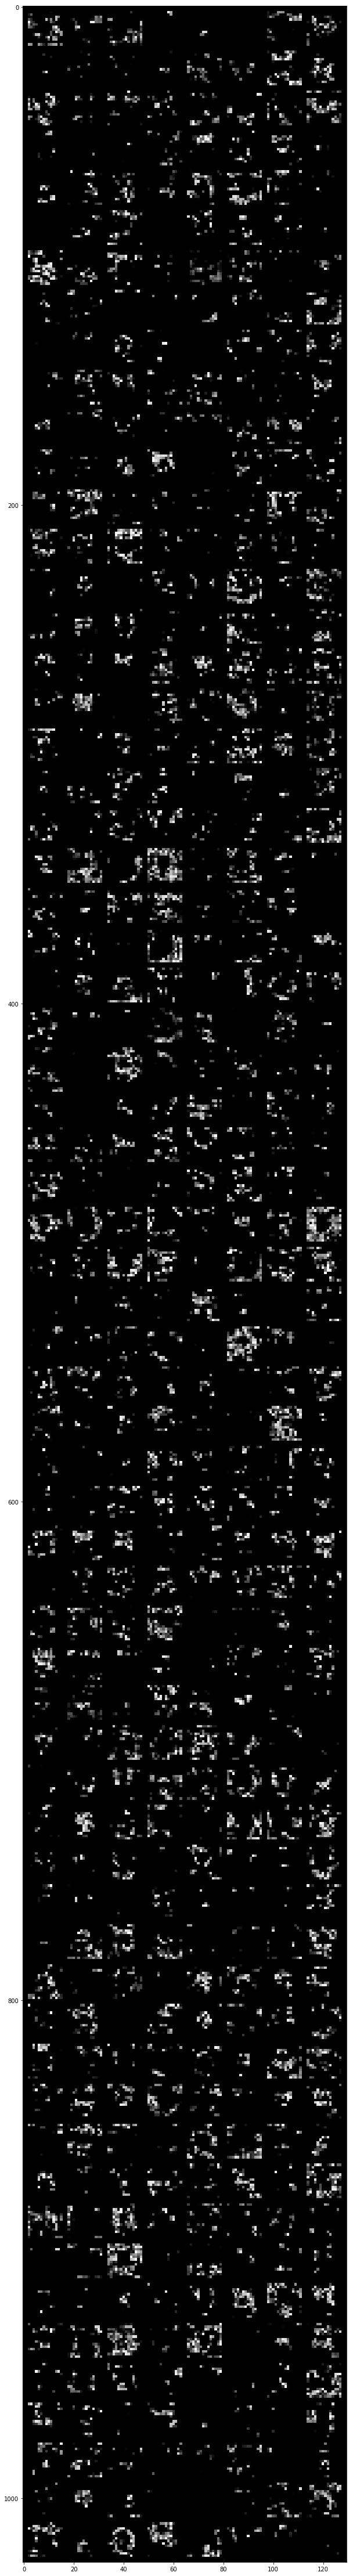

In [333]:
squeezed_ava = torch.squeeze(model_t(ava)[-1].data)
print(squeezed_ava.size())
reshaped_ava = squeezed_ava.view(-1,1,squeezed_ava.size()[1],squeezed_ava.size()[1])

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(make_grid(reshaped_ava))

torch.Size([512, 14, 14])


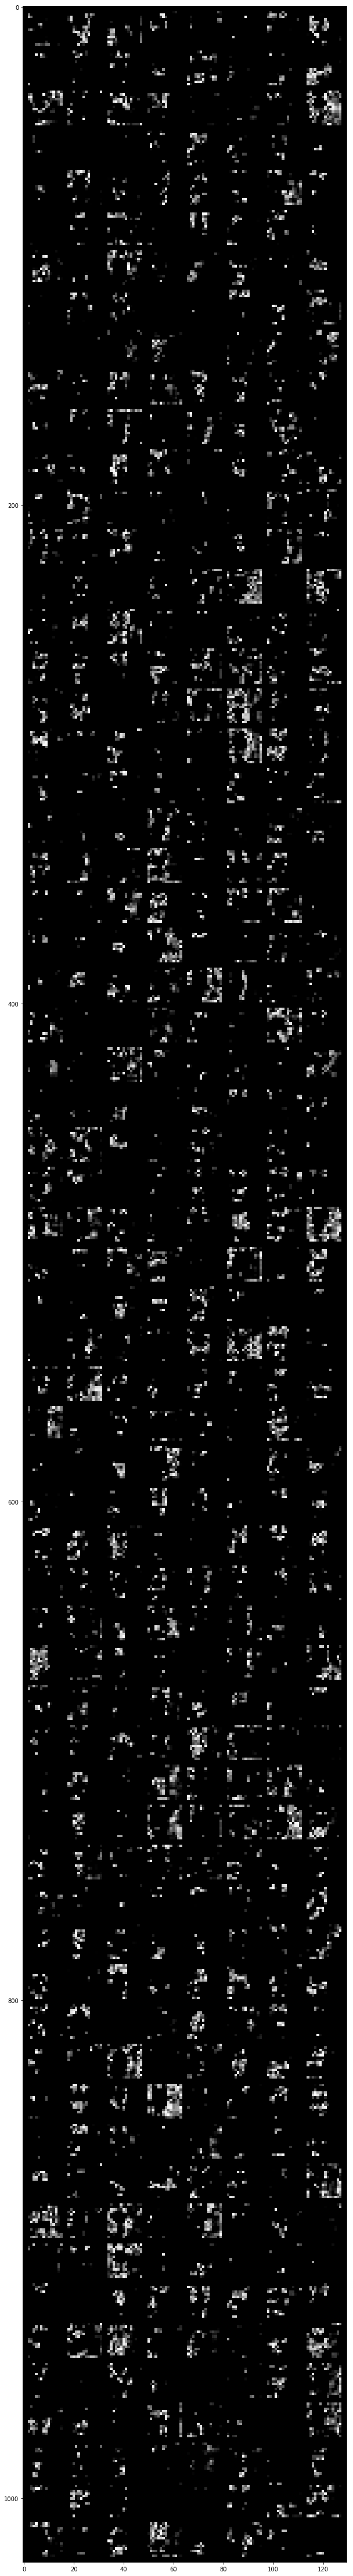

In [334]:
squeezed_mona = torch.squeeze(model_t(mona)[-1].data)
print(squeezed_mona.size())
reshaped_mona = squeezed_mona.view(-1,1,squeezed_mona.size()[1],squeezed_mona.size()[1])

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(make_grid(reshaped_mona))

(14, 14, 512)


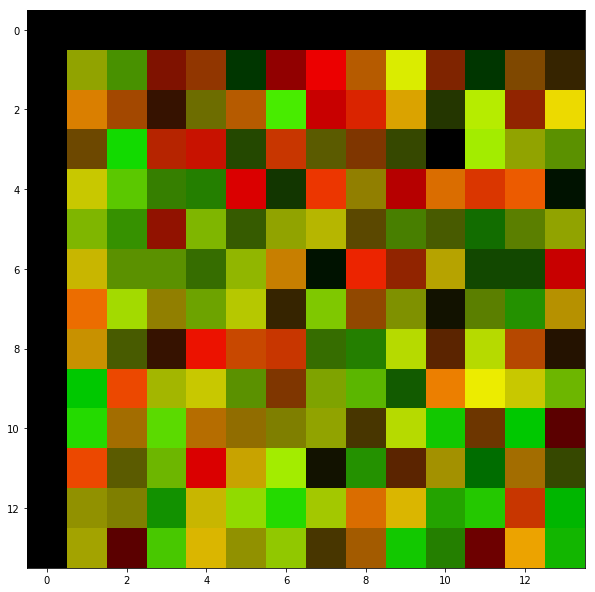

In [335]:
ava_arr = squeezed_ava.numpy().transpose(1,2,0)
mona_arr = squeezed_mona.numpy().transpose(1,2,0)
print(ava_arr.shape)

pm = PatchMatchOrig(ava_arr,mona_arr, 3)
plt.imshow(pm.visualize()) # visualise a random nnf

In [338]:
pm.propagate(iters=3)
#     pm.back_propagate()

Done


/home/harsh/ml/Deep-Image-Analogy/notebooks/../src/PatchMatch/PatchMatchOrig.py:33: RuntimeWarning: invalid value encountered in true_divide
  return np.sum((self.A[ai-dx0:ai+dx1, aj-dy0:aj+dy1]-self.B[bi-dx0:bi+dx1, bj-dy0:bj+dy1])**2) / (dx1+dx0) / (dy1+dy0)
/home/harsh/ml/Deep-Image-Analogy/notebooks/../src/PatchMatch/PatchMatchOrig.py:33: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum((self.A[ai-dx0:ai+dx1, aj-dy0:aj+dy1]-self.B[bi-dx0:bi+dx1, bj-dy0:bj+dy1])**2) / (dx1+dx0) / (dy1+dy0)


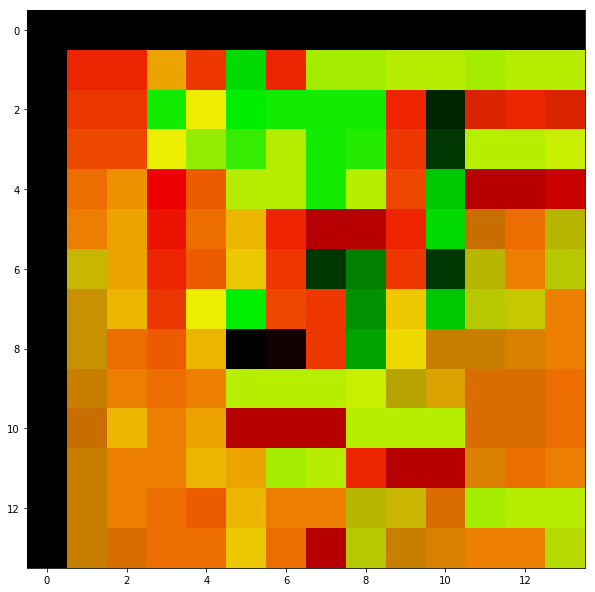

In [339]:
plt.imshow(pm.visualize())

In [340]:
ava_arr.shape

(14, 14, 512)

In [341]:
def reconstruct(self):
    ans = np.zeros_like(self.A)
    for i in range(self.A.shape[0]):
        for j in range(self.A.shape[1]):
            pos = self.nnf[i,j]
            ans[i,j] = self.B[pos[0], pos[1]]
    return ans


def reconstruct_img_voting( patch_size=3,arr_v=None):
        b_prime = np.zeros_like(arr_v,dtype=np.uint8)

        for i in range(arr_v.shape[0]): #traverse down a
            for j in range(arr_v.shape[1]): #traverse across a
                
                dx0 = dy0 = patch_size//2
                dx1 = dy1 = patch_size//2 + 1
                dx0 = min(i,dx0)
                dx1 = min(arr_v.shape[0]-i, dx1)
                dy0 = min(j, dy0)
                dy1 = min(arr_v.shape[1]-j, dy1)
                
                votes = pm.nnf[i-dx0:i+dx1, j-dy0:j+dy1] 
                b_patch = np.zeros(shape=(votes.shape[0],votes.shape[1],arr_v.shape[2]))
                
                for p_i in range(votes.shape[0]):
                    for p_j in range(votes.shape[1]):
                     
                        b_patch[p_i, p_j] = arr_v[votes[p_i,p_j][0] , votes[p_i,p_j][1]]

                averaged_patch = np.average(b_patch,axis=(0,1))
                b_prime[i, j] = averaged_patch[:]
        plt.imshow(b_prime[:,:,::-1])
        plt.show()

In [342]:
ava_big = np.squeeze(ava.data.numpy()).transpose(1,2,0)
mona_big = np.squeeze(mona.data.numpy()).transpose(1,2,0)

pm.A = ava_big
pm.B = mona_big

In [343]:
ava_big.shape
mona_big.shape

(448, 448, 3)

In [346]:
final_img = np.zeros_like(ava_big)
for i in range(7*2):
    for j in range(7*2):
        x,y = pm.nnf[i,j]
        if final_img[32*i:32*(i+1),32*j:32*(j+1)].shape == mona_big[32*y:32*(y+1),32*x:32*(x+1)].shape:
            final_img[32*i:32*(i+1),32*j:32*(j+1)] = mona_big[32*y:32*(y+1),32*x:32*(x+1)]
            print("done")
#         plt.imshow(ava_big[7*x:7*x+7,7*y:7*y+7])
#         plt.show()

final_img[:,:,0] = (final_img[:,:,0]*.229)+.485
final_img[:,:,1] = (final_img[:,:,1]*.224)+.456
final_img[:,:,2] = (final_img[:,:,2]*.225)+.406



# transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225]
        

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


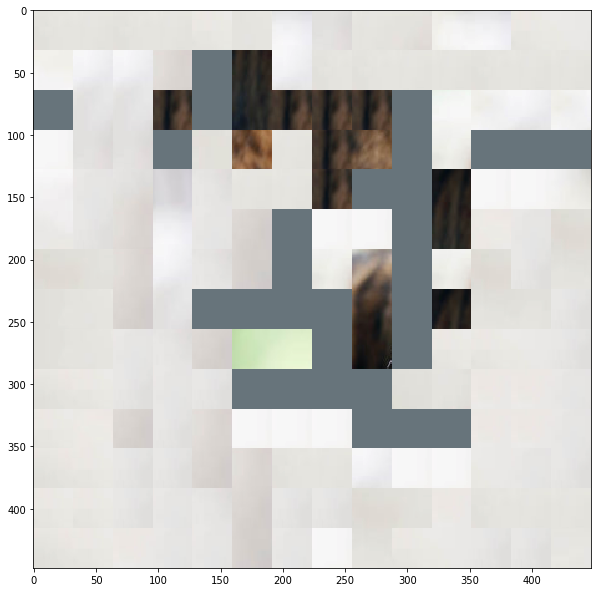

In [347]:
plt.imshow(final_img[:,:,::-1])

In [ ]:
plt.imshow(ava_big/6+final_img[:,:,::-1])

In [ ]:
plt.imshow(mona_big)
plt.show()
plt.imshow(final_img[:,:,::-1]/2 +mona_big/2)
plt.show()

In [19]:
mona_big.shape

(448, 448, 3)